# Capacitated Lot-Sizing Problem (CLSP)


In this guide, we’ll explore the Capacitated Lot-Sizing Problem (CLSP), which is a classic optimization problem in operations research. The CLSP involves determining the optimal production quantities of multiple items over a planning horizon, subject to capacity constraints and demand requirements. The objective is to minimize the total production, fixed and inventory holding costs while satisfying the demand for each item. The fundamental economic question here is: 

> How much to produce of each product and when?

The problem's algebraic representation typically takes the following format:

### Indices:

- $k$ ; products
- $j$ ; resources
- $t$ ; time periods
- $kj$ ; products $k$ that can be handled by resource $j$

### Given Data:

- $d_{kt}$ ; demand of product $k$ in period $t$
- $s_k$ ; fixed setup cost for product $k$
- $h_k$ ; holding cost for product $k$
- $c_{tj}$ ; production capacity of resource $j$ in period $t$

### Decision Variables:

- $X_{kt}$ ; lot size of product $k$ in period $t$ where $X_{kt} \ge 0 \: \forall k,t$
- $Y_{kt}$ ; indicates if product $k$ is manufactures in period $t$ where $Y_{kt} \in \{0, 1\} \: \forall k,t$
- $Z_{kt}$ ; stock of product $k$ in period $t$ where $Z_{kt} \ge 0 \: \forall k,t$

### Constraints:

- Stock balance equation ${kt}$: $Z_{kt} = Z_{kt-1} + X_{kt} - d_{kt}$
- Ensure production ${kt}$: $X_{kt} \le Y_{kt} \cdot \sum_{tau} d_{ktau}$
- Capacity restriction ${jt}$: $\sum_{kj} X_{kt} \le c_{tj}$
- Objective Function: Minimize $\sum_k\sum_t(s_k \cdot Y_{kt} + h_k \cdot Z_{kt})$

## Install dependencies

In [1]:
# Install dependencies
! pip install -q gamspy plotly kaleido

## Importing Modules
The `gamspy` Python package is loaded in order to access GAMSPy syntax.

In [2]:
from gamspy import (
    Container,
    Set,
    Alias,
    Parameter,
    Variable,
    Equation,
    Sum,
    Model,
    Sense,
)
import pandas as pd
from itertools import product
import plotly.express as px

### Data

In [3]:
products = ["Product_A", "Product_B", "Product_C"]
time_periods = [1, 2, 3, 4]
resources = ["Resource_A", "Resource_B"]

kj = pd.DataFrame(product(products, resources))

demand_data = pd.DataFrame(
    {
        "Product_A": {1: 100, 2: 150, 3: 120, 4: 180},
        "Product_B": {1: 80, 2: 100, 3: 90, 4: 120},
        "Product_C": {1: 50, 2: 60, 3: 70, 4: 80},
    }
).unstack()

setup_cost_data = pd.DataFrame(
    [("Product_A", 100), ("Product_B", 200), ("Product_C", 300)]
)
holding_cost_data = pd.DataFrame(
    [("Product_A", 0.2), ("Product_B", 0.1), ("Product_C", 0.6)]
)

capacity_data = pd.DataFrame(
    [
        ("Resource_A", 1, 340),
        ("Resource_B", 1, 340),
        ("Resource_A", 2, 330),
        ("Resource_B", 2, 330),
        ("Resource_A", 3, 300),
        ("Resource_B", 3, 300),
        ("Resource_A", 4, 380),
        ("Resource_B", 4, 380),
    ]
)

In [4]:
# Container definition
m = Container()

# SETS
k = Set(m, name="k", description="products", records=products)
j = Set(m, name="j", description="resources", records=resources)
t = Set(m, name="t", description="time periods", records=time_periods)
KJ = Set(
    m,
    name="KJ",
    domain=[k, j],
    description="products k that can be handled by resource j",
    records=kj,
)

# ALIAS
tau = Alias(m, name="tau", alias_with=t)

# PARAMETERS
d = Parameter(
    m,
    name="d",
    domain=[k, t],
    description="demand of product k in period t",
    records=demand_data,
)
s = Parameter(
    m,
    name="s",
    domain=k,
    description="fixed setup cost for product k",
    records=setup_cost_data,
)
h = Parameter(
    m,
    name="h",
    domain=k,
    description="holding cost for product k",
    records=holding_cost_data,
)
c = Parameter(
    m,
    name="c",
    domain=[j, t],
    description="production capacity of resource j in period t",
    records=capacity_data,
)

# VARIABLES
X = Variable(
    m,
    name="X",
    domain=[k, t],
    type="positive",
    description="lot size of product k in period t",
)
Y = Variable(
    m,
    name="Y",
    domain=[k, t],
    type="binary",
    description="indicates if product k is manufactured in period t",
)
Z = Variable(
    m,
    name="Z",
    domain=[k, t],
    type="positive",
    description="stock of product k in period t",
)

# **Formulation**

\begin{align}
\text{minimize} \qquad & \text{obj}:= \sum_k\sum_t \text{s}_k \cdot \text{Y}_{k,t} + \text{h}_k \cdot \text{Z}_{k,t} \\
\text{subject to}  \qquad & \text{Z}_{k,t} = Z_{k,t-1} + X_{k,t} - d_{k,t} & (\forall{k,t}) \\
& X_{k,t} \le Y_{k,t} \cdot \sum_{tau} d_{k,tau} & (\forall{k,t}) \\
& \sum_{kj} X_{kt} \le c_{jt} & (\forall j,t)\\
& Z_{k,t} = 0 & (\forall k) \\
& X_{k,t} \geq 0 & (\forall k,t) \\
& Z_{k,t} \geq 0 & (\forall k,t) \\
& Y_{k,t} \in \{0,1\} & (\forall k,t)
\end{align}

(1) Represents the Objective Function <br>
(2) Represents the Stock balance equation <br>
(3) Represents the production limits <br>
(4) Represents the Capacity constraint <br>
(5) Forces the inventory at the end of the planning horizon to be zero <br>
(6) and (7) represent non-negativity constraints <br>
(8) Represents the binary constraint




In [5]:
# FORMULATIONS

objective = Sum((k, t), s[k] * Y[k, t] + h[k] * Z[k, t])

stock = Equation(m, name="stock", domain=[k, t], description="Stock balance equation")
stock[...] = Z[k, t] == Z[k, t.lag(1)] + X[k, t] - d[k, t]

production = Equation(
    m, name="production", domain=[k, t], description="Ensure production"
)
production[...] = X[k, t] <= Y[k, t] * Sum(tau, d[k, tau])

capacity = Equation(
    m, name="capacity", domain=[j, t], description="Capacity restriction"
)
capacity[...] = Sum(KJ[k, j], X[k, t]) <= c[j, t]

Z.fx[k, t].where[t.last] = 0

clsp = Model(
    m,
    name="CLSP",
    problem="MIP",
    equations=m.getEquations(),
    sense=Sense.MIN,
    objective=objective,
)

clsp.solve()

,Solver Status,Model Status,Objective,Num of Equations,Num of Variables,Model Type,Solver,Solver Time
0,Normal,OptimalGlobal,1694.0,33,37,MIP,CPLEX,0.0


### Results

In [6]:
print("Objective function value:", clsp.objective_value)

Objective function value: 1694.0


### Production Quantities

In [7]:
X.records.pivot(index="t", columns="k", values="level")

k,Product_A,Product_B,Product_C
t,,,
1,100.0,90.0,110.0
2,150.0,180.0,0.0
3,120.0,0.0,150.0
4,180.0,120.0,0.0


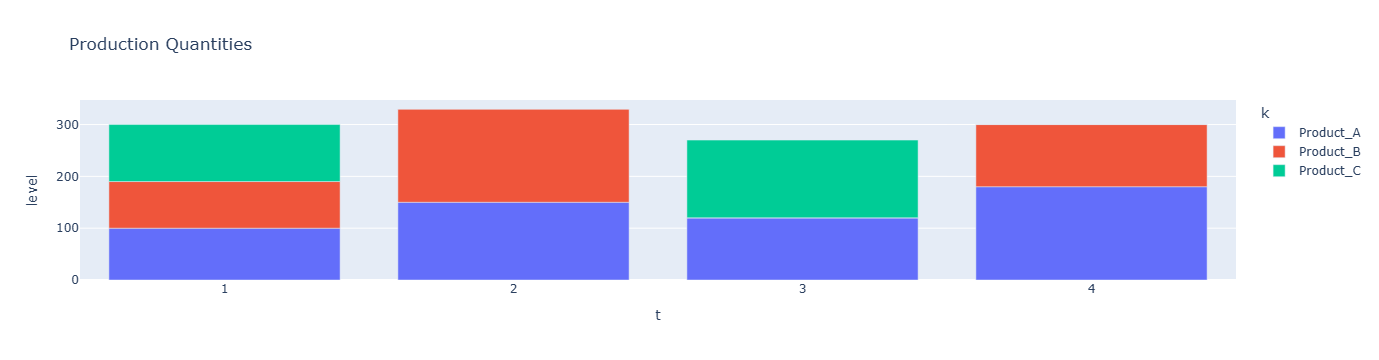

In [8]:
fig = px.bar(X.records, x="t", y="level", color="k", title="Production Quantities")
fig.show()

Stock Levels

In [9]:
Z.records.pivot(index="t", columns="k", values="level")

k,Product_A,Product_B,Product_C
t,,,
1,0.0,10.0,60.0
2,0.0,90.0,0.0
3,0.0,0.0,80.0
4,0.0,0.0,0.0


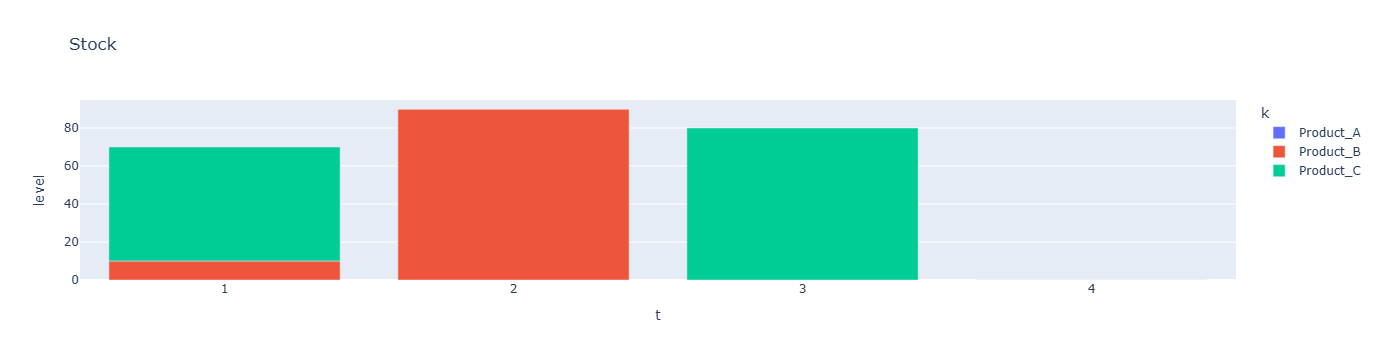

In [10]:
fig = px.bar(Z.records, x="t", y="level", color="k", title="Stock")
fig.show()